# BOSS Calibration Tutorial

The purpose of this tutorial is to reconstruct and document the calibration steps from detected electrons to calibrated flux, as described [here](https://trac.sdss3.org/wiki/BOSS/pipeline/FluxToPhotons) (requires SDSS3 login).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as fits

In [3]:
import bossdata
print(bossdata.__version__)

0.3.1dev


In [4]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

With the default plate 6641, all files are mirrored from https://dr12.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/6641/.

Using MJD 56383.
Fiber 1 read out by blue camera b1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 1 objtype is QSO.


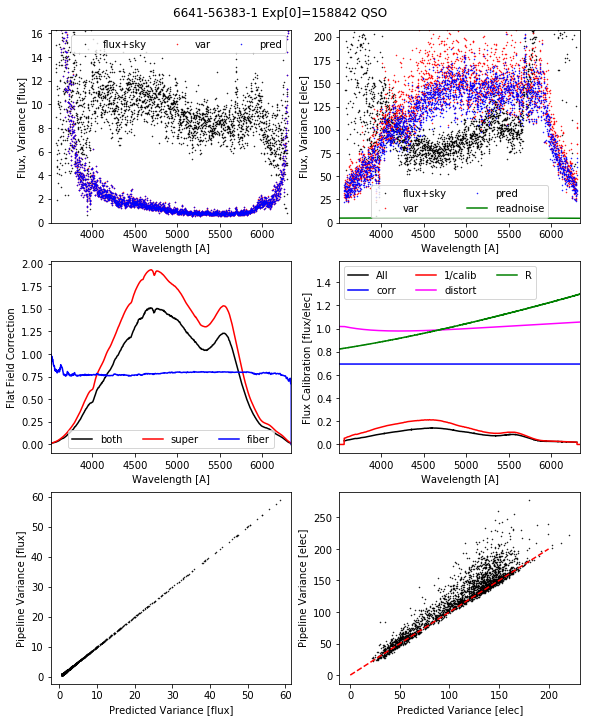

In [5]:
def plot_calib(plate=6641, mjd=None, fiber=1, expidx=0, band='blue',
               mask=None, save=None):
    """
    """
    assert band in 'blue', 'red'
    
    # Infer the MJD if possible, when none is specified.
    if mjd is None:
        mjds = bossdata.meta.get_plate_mjd_list(plate, finder, mirror)
        if len(mjds) == 0:
            print('Plate {} has never been observed with good quality.')
        elif len(mjds) > 1:
            print('Plate {} observed multiple on multiple MJDs (pick one): {}.'.format(','.join(mjds)))
        else:
            mjd = mjds[0]
            print('Using MJD {}.'.format(mjd))
        if not mjd:
            return

    # Which spectrograph does this fiber belong to?
    num_fibers = bossdata.plate.get_num_fibers(plate)
    spec_num = 1 if fiber <= num_fibers // 2 else 2
    camera = band[0] + str(spec_num)
    print('Fiber {} read out by {} camera {}.'.format(fiber, band, camera))

    # Load the list of exposures used for the science coadd of PLATE-MJD
    # and the associated calibration exposures.
    spec_name = finder.get_spec_path(plate, mjd, fiber, lite=True)
    exposures = bossdata.spec.SpecFile(mirror.get(spec_name)).exposures
    
    nexp = len(exposures.table)
    if expidx >= nexp:
        print('Invalid exposure index {} (should be 0-{}).'
              .format(expidx, nexp - 1))
        return
    expnum = exposures.table[expidx]['science']
    print('Analyzing exposure[{}] = #{} of {} used in coadd.'
          .format(expidx, expnum, nexp))
        
    # Load the calibrated flux and wavelength solution and ivars from the spCFrame file.
    name = exposures.get_exposure_name(expidx, camera, 'spCFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spCFrame = bossdata.plate.FrameFile(path, calibrated=True)
    data = spCFrame.get_valid_data(
        [fiber], include_sky=True,use_ivar=True, pixel_quality_mask=mask)[0]
    wave, flux, sky, ivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
    
    # Lookup the metadata for this fiber.
    fiber_index = spCFrame.get_fiber_offsets([fiber])[0]
    #print(np.where(spCFrame.plug_map['OBJTYPE'] == 'SKY             ')[0])
    info = spCFrame.plug_map[fiber_index]
    objtype = info['OBJTYPE'].rstrip()
    print('Fiber {} objtype is {}.'.format(fiber, objtype))
    
    # Load the uncalibrated flux in flat-fielded electrons from the spFrame file.
    name = exposures.get_exposure_name(expidx, camera, 'spFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spFrame = bossdata.plate.FrameFile(path, calibrated=False)
    data = spFrame.get_valid_data(
        [fiber], include_sky=True, use_ivar=True, pixel_quality_mask=mask)[0]
    ewave, eflux, esky, eivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
    
    # Load the fluxcorr for this fiber.
    name = exposures.get_exposure_name(expidx, camera, 'spFluxcorr')
    path = mirror.get(finder.get_plate_path(plate, name))
    with fits.open(path) as spFluxcorr:
        corr = spFluxcorr[0].data[fiber_index]

    # Load the fluxcalib for this fiber.
    name = exposures.get_exposure_name(expidx, camera, 'spFluxcalib')
    path = mirror.get(finder.get_plate_path(plate, name))
    with fits.open(path) as spFluxcalib:
        spcalib = spFluxcalib[0].data[fiber_index]
        invcalib = spcalib.copy()
        invcalib[spcalib > 0] = 1 / spcalib[spcalib > 0]
        
    # The spFrame uses a TraceSet instead of tabulated log(lambda) values.
    # The b-camera spCFrame, spFluxcorr arrays have 16 extra entries compared
    # with spFrame, so trim those now.
    n = len(ewave)
    wave = wave[:n]
    assert np.allclose(wave, ewave)
    flux = flux[:n]
    sky = sky[:n]
    ivar = ivar[:n]
    corr = corr[:n]
    
    # Load the superflat from the spFrame file.
    superflat = spFrame.get_superflat([fiber])[0]
    
    # Load the fiberflat and neff from the spFlat file.
    name = exposures.get_exposure_name(expidx, camera, 'spFlat')
    path = mirror.get(finder.get_plate_path(plate, name))
    with fits.open(path) as spFlat:
        fiberflat = spFlat[0].data[fiber_index]
        neff = bossdata.plate.TraceSet(spFlat[3]).get_y()[fiber_index]
        
    # Get the flux distortion map for this plate's coadd.
    path = mirror.get(finder.get_fluxdistort_path(plate, mjd))
    with fits.open(path) as spFluxdistort:
        distort_coadd = spFluxdistort[0].data[fiber_index]
        # Build the coadded loglam grid.
        hdr = spFluxdistort[0].header
        loglam0, idx0, dloglam = hdr['CRVAL1'], hdr['CRPIX1'], hdr['CD1_1']
        loglam = loglam0 + (np.arange(len(distort_coadd)) - idx0) * dloglam
        wave_coadd = 10 ** loglam
        # Linearly interpolate the distortion to our wavelength grid.
        distort = np.interp(wave, wave_coadd, distort_coadd)
        # Calculate ratio of dloglam=10e-4 bin sizes to native pixel binsizes.
        R = dloglam / np.gradient(np.log10(wave))
        
    # Calculate the raw electron counts, including the sky.
    electrons = superflat * fiberflat * (eflux + esky)
    
    # Estimate the readnoise per wavelength pixel.
    readnoise = dict(blue=2.0, red=3.0)[band] # electrons / pixel
    scale = np.sqrt(8 * np.log(2))
    ##scale = np.sqrt(4 * np.pi)
    readnoise *= neff * scale
    
    # Calculate the pipeline variance in detected electrons.
    nvar = (superflat * fiberflat) ** 2 / eivar
    
    # Predict what the variance in detected electrons should be.
    nvar_pred = electrons + readnoise ** 2
    
    # Build the eflux to flux calibration from its components.
    nonzero = eflux != 0
    ecalib1 = np.zeros_like(eflux)
    ecalib1[nonzero] = flux[nonzero] / eflux[nonzero]
    ecalib2 = corr * distort * R * invcalib
    assert np.allclose(ecalib1, ecalib2, rtol=1e-3, atol=1e-3)
    
    # Calculate the flux variance.
    var = np.zeros_like(ivar)
    valid = ~ivar.mask
    var[valid] = 1 / ivar[valid]
    
    # Predict the flux variance by scaling the eflux variance.
    var_pred = var.copy()
    var_pred[valid] = ecalib1[valid] ** 2 / eivar[valid]
    
    # Limit plots to wavelengths where the fiberflat is nonzero.
    nonzero = np.where(fiberflat > 0)[0]
    wmin, wmax = wave[nonzero[[0,-1]]]
    
    # Initialize plots.
    fig, ax = plt.subplots(3, 2, figsize=(8.5, 11))
    ax = ax.flatten()

    ax[0].plot(wave, flux + sky, 'k.', ms=1, label='flux+sky')
    ax[0].plot(wave, var, 'r.', ms=1, label='var')
    ax[0].plot(wave, var_pred, 'b.', ms=1, label='pred')
    ax[0].set_xlim(wmin, wmax)
    ax[0].set_ylim(0, np.percentile(flux + sky, 99))
    ax[0].set_xlabel('Wavelength [A]')
    ax[0].set_ylabel('Flux, Variance [flux]')
    ax[0].legend(ncol=3)

    ax[1].plot(wave, eflux + esky, 'k.', ms=1, label='flux+sky')
    ax[1].plot(wave, nvar, 'r.', ms=1, label='var')
    ax[1].plot(wave, nvar_pred, 'b.', ms=1, label='pred')
    ax[1].plot(wave, readnoise, 'g-', label='readnoise')
    ax[1].set_xlim(wmin, wmax)
    ax[1].set_ylim(0, np.percentile(nvar, 99))
    ax[1].set_xlabel('Wavelength [A]')
    ax[1].set_ylabel('Flux, Variance [elec]')
    ax[1].legend(ncol=2)
    
    ax[2].plot(wave, superflat * fiberflat, 'k-', label='both')
    ax[2].plot(wave, superflat, 'r-', label='super')
    ax[2].plot(wave, fiberflat, 'b-', label='fiber')
    ax[2].set_xlim(wmin, wmax)
    ax[2].set_xlabel('Wavelength [A]')
    ax[2].set_ylabel('Flat Field Correction')
    ax[2].legend(ncol=3)
    
    ax[3].plot(wave, ecalib1, 'k-', label='All')
    ax[3].plot(wave, corr, 'b-', label='corr')
    ax[3].plot(wave, invcalib, 'r-', label='1/calib')
    ax[3].plot(wave, distort, '-', c='magenta', label='distort')
    ax[3].plot(wave, R, 'g-', label='R')
    ax[3].set_xlim(wmin, wmax)
    ax[3].set_xlabel('Wavelength [A]')
    ax[3].set_ylabel('Flux Calibration [flux/elec]')
    ax[3].legend(ncol=3)
    
    ax[4].plot(var_pred[nonzero], var[nonzero], 'k.', ms=1)
    ax[4].set_xlabel('Predicted Variance [flux]')
    ax[4].set_ylabel('Pipeline Variance [flux]')

    ax[5].plot(nvar_pred, nvar, 'k.', ms=1)
    ax[5].plot([0, 200], [0, 200], 'r--')
    ax[5].set_xlabel('Predicted Variance [elec]')
    ax[5].set_ylabel('Pipeline Variance [elec]')
    
    title = '{}-{}-{} Exp[{}]={} {}'.format(
        plate, mjd, fiber, expidx, expnum, objtype)
    plt.suptitle(title)
    plt.subplots_adjust(top=0.95, right=0.99)
    if save:
        plt.savefig(save)

plot_calib()

Using MJD 56383.
Fiber 486 read out by blue camera b1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 486 objtype is SKY.


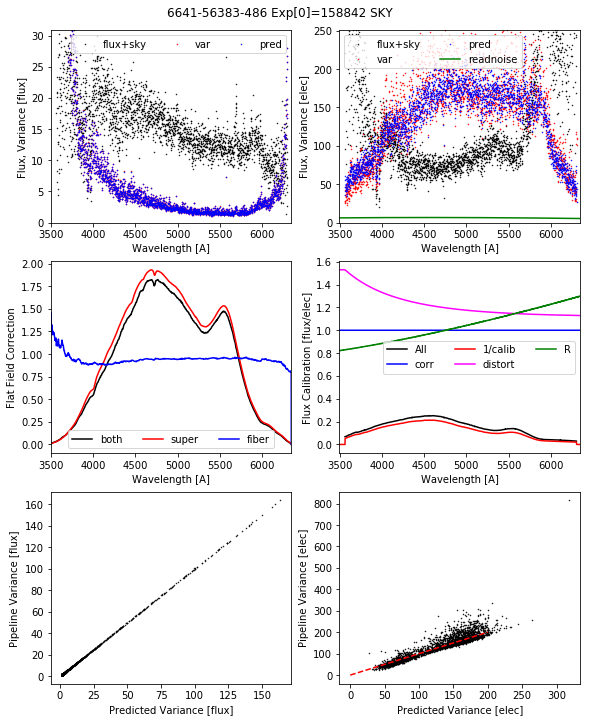

In [6]:
plot_calib(fiber=486)